In [4]:
# Useful for debugging
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from distgen.dist import Uniform
from distgen.dist import SuperGaussian
from distgen.dist import Norm
from distgen.physical_constants import unit_registry

from matplotlib import pyplot as plt

import numpy as np

# Metrics for comparing different distributions
---
In some cases, it is desired to target a particular distribution shape in an optimization.  To facilitate this the following two metrics are implemented:

## Kullback-Leibler (Relative Entropy)
Defined as:
$D_{KL}(P|Q) = \int_{-\infty}^{\infty}p(x)\ln{\left(\frac{p(x)}{q(x)}\right)} dx$

Note that this is not well defined in regions where the PDF $q(x)=0$.  This causes trouble for distributions like a uniform distribution.  For this, its suggested to use a SuperGaussian to approximate the uniform dist (see below).

https://en.wikipedia.org/wiki/Kullback–Leibler_divergence

In [6]:
L = 2*unit_registry('ps')
avg_t_sg = 0*unit_registry('ps')
sigma_t_sg = L/np.sqrt(12)

In [7]:
sg = SuperGaussian('t', avg_t=avg_t_sg, sigma_t=sigma_t_sg, p=12)

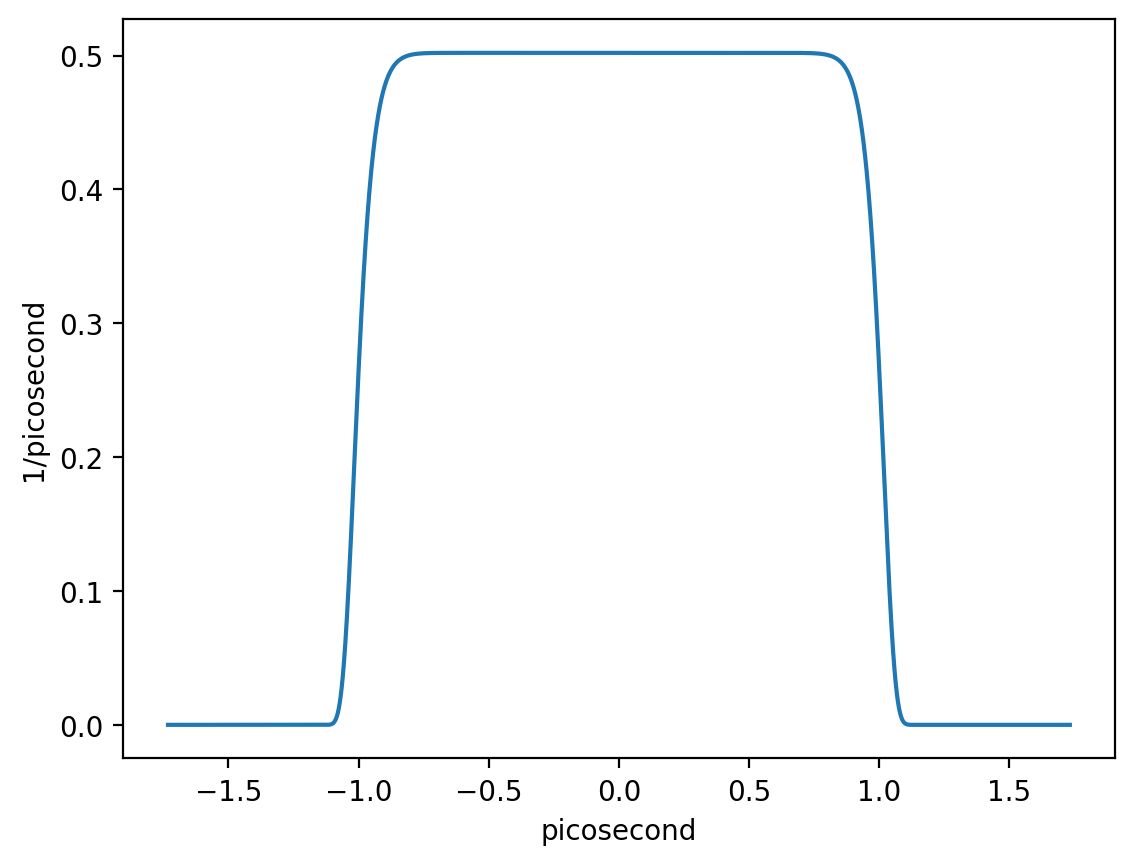

In [8]:
tsg, Psg = sg.get_x_pts(), sg.pdf()
plt.plot(tsg, Psg);

In [9]:
norm = Norm('t', avg_t=avg_t_sg, sigma_t=sigma_t_sg)

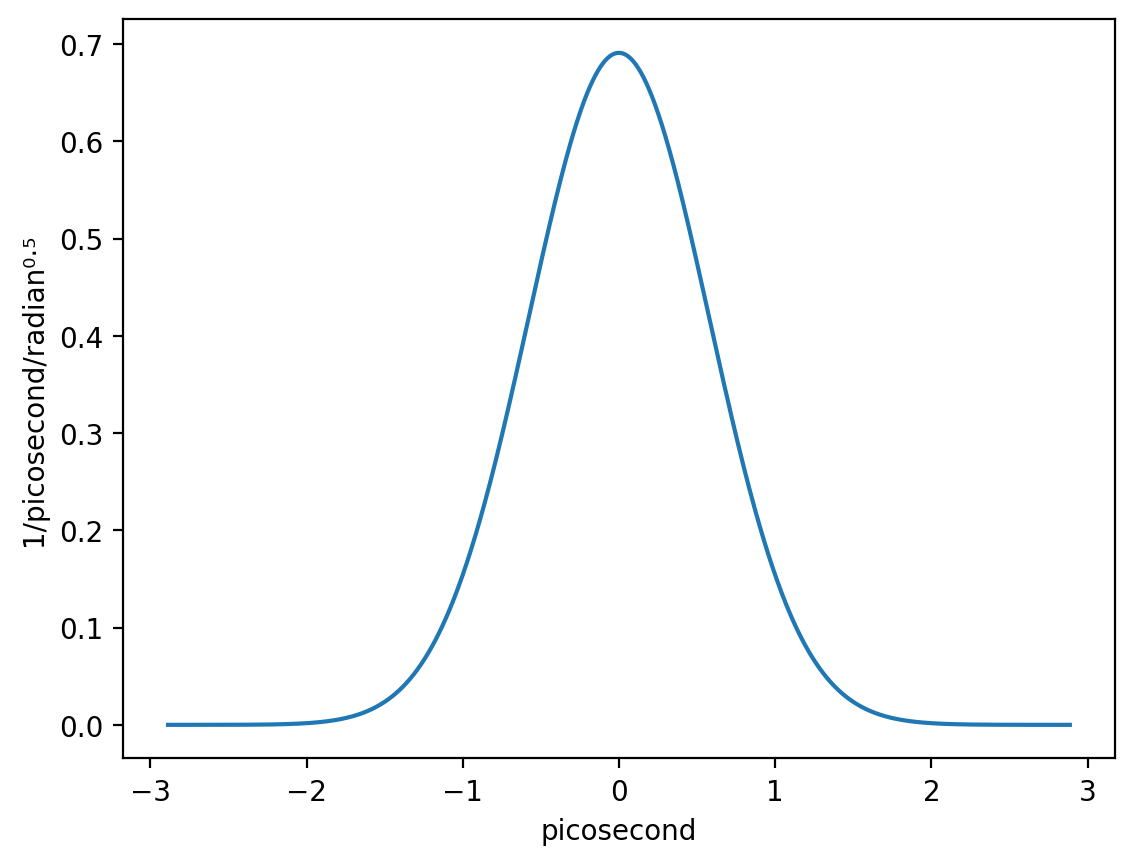

In [10]:
tn, Pn = norm.get_x_pts(), norm.pdf()
plt.plot(tn, Pn);

In [11]:
from distgen.metrics import kullback_liebler_div

In [12]:
kullback_liebler_div(tn, Pn, tsg, Psg, as_float=False)

4.301370109274345 <Unit('dimensionless')>

The functions work with raw NumPy arrays, and support both float output or Pint Quantity outputs:

In [13]:
kullback_liebler_div(tn.magnitude, Pn.magnitude, tsg.magnitude, Psg.magnitude, as_float=True)

4.301370109274345

In addition to the Kullback Liebler Divergence, the residual squared between two distributions is implemented:


In [14]:
from distgen.metrics import res2

In [15]:
res2(tn, Pn, tsg, Psg, as_float=False, normalize=True)

0.11983271504891024 <Unit('dimensionless')>

In [16]:
res2(tn.magnitude, Pn.magnitude, tsg.magnitude, Psg.magnitude, as_float=True)

0.058441901838167956

# Helper Functions
---

In [17]:
from distgen.metrics import resample_pq

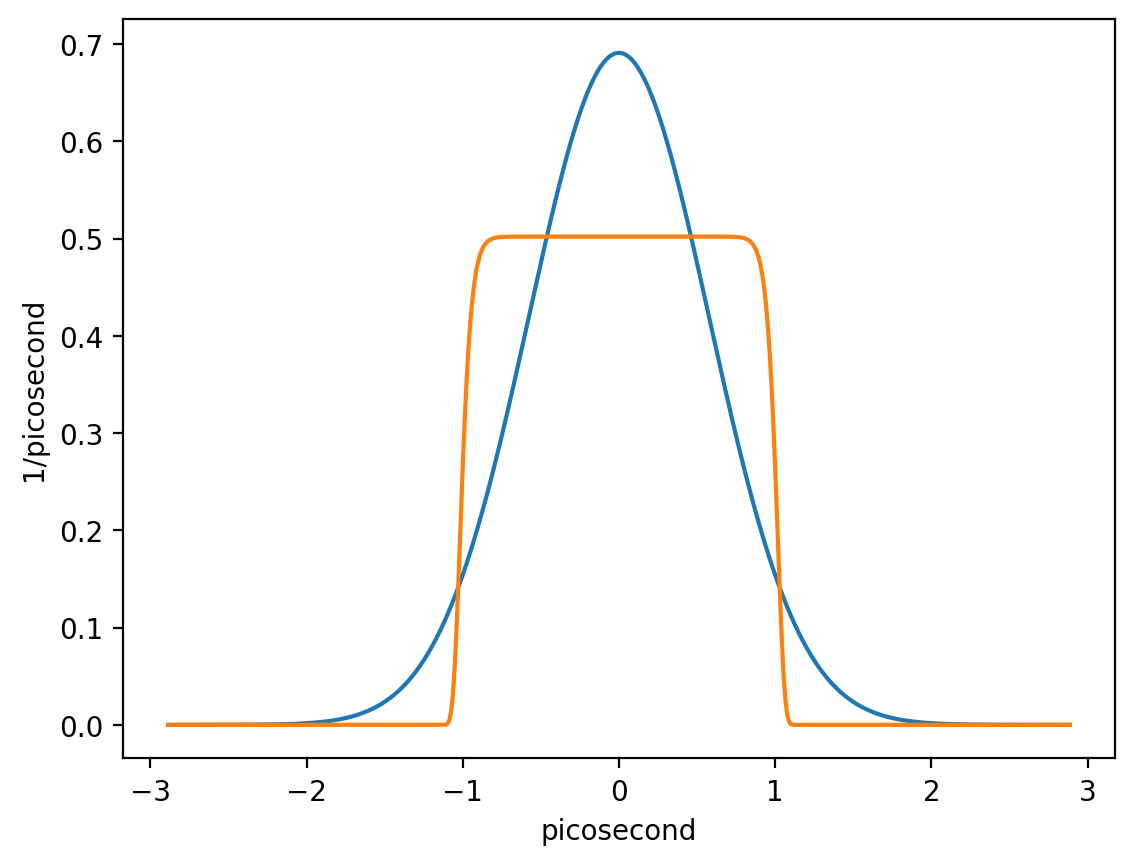

In [18]:
resample_pq(tn, Pn, tsg, Psg, plot=True);

In [19]:
dist_yaml="""
n_particle: 30000
r_dist:
  truncation_fraction:
    units: dimensionless
    value: 0.5
  truncation_radius:
    units: mm
    value: 2.3319043122
  type: rg
random_type: hammersley
start:
  MTE:
    units: meV
    value: 130
  type: cathode
t_dist:
  p:
    units: ''
    value: 1
  sigma_t:
    units: ps
    value: 10
  type: sg
total_charge:
  units: pC
  value: 100
"""

In [20]:
from distgen import Generator

In [21]:
D = Generator(dist_yaml)

In [22]:
P = D.run()

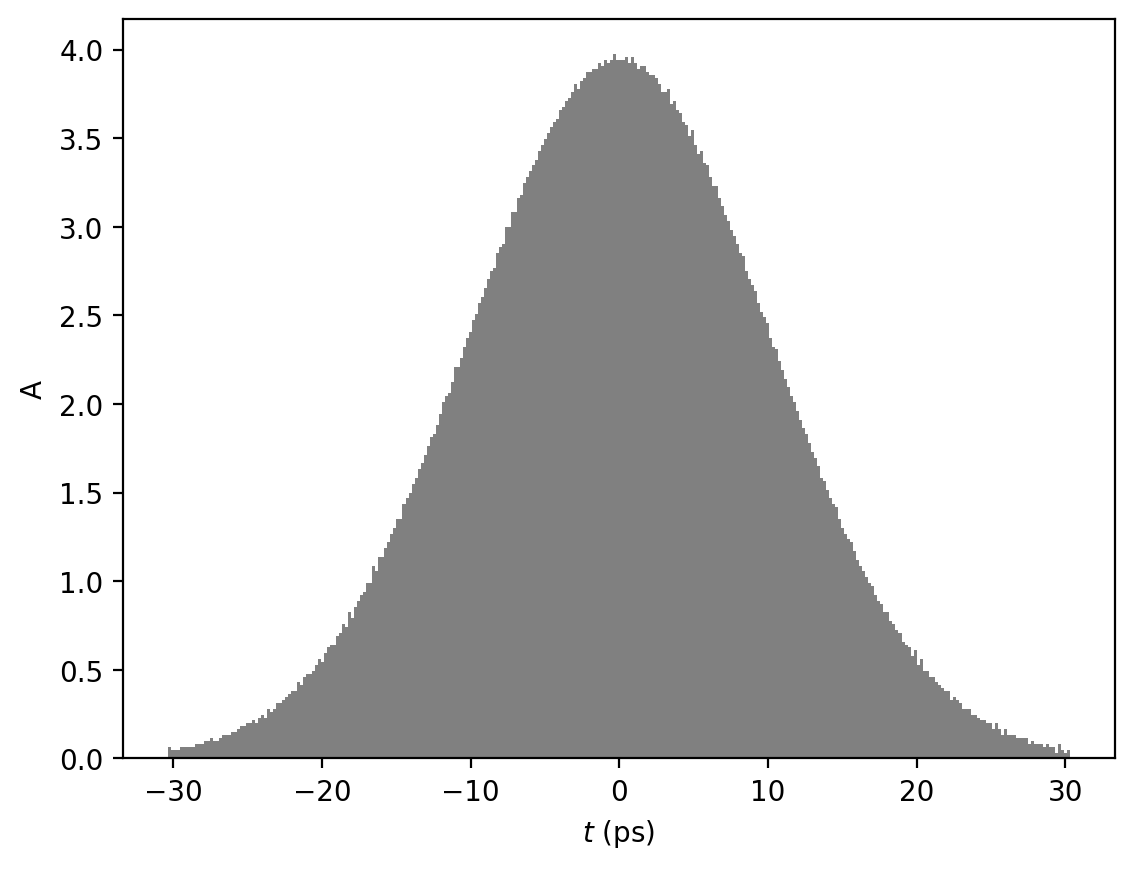

In [23]:
P.plot('t')

In [24]:
def get_1d_profile(particle_group, var, bins=None):
    
    if not bins:
        n = len(particle_group)
        bins = int(n/100)
    
    w = particle_group['weight']
    
    hist, bin_edges = np.histogram(particle_group[var], bins=bins, weights=w)
    hist_x = bin_edges[:-1] + np.diff(bin_edges) / 2

    return hist_x, hist


def get_current_profile(particle_group, bins=None):
    return get_1d_profile(particle_group, 't', bins=bins)



def rms_equivalent_1d_nonuniformity(particle_group, var, bins=None, method='res2', **kwargs):

    hist_x, hist = get_1d_profile(particle_group, var, bins=bins)

    mean_x, sigma_x = particle_group[f'mean_{var}'], particle_group[f'sigma_{var}']
    
    x_units = P.units(var).unitSymbol
    
    params = {f'avg_{var}':mean_x*unit_registry(x_units),
              f'sigma_{var}':sigma_x*unit_registry(x_units)}
    
    # Get RMS equivalent uniform beam and compute non-uniformity
    if(method=='kl_div'):
        
        if('p' in kwargs):
            p = kwargs['p']
        else:
            p = 12
            
        params['p'] = p

        sg = SuperGaussian(var, **params)
        x = sg.get_x_pts(n=len(hist))
        px = sg.pdf(x)
        
        return kullback_liebler_div(hist_x, hist, x.magnitude, px.magnitude, as_float=True)
    
    elif(method=='res2'):
        
        u = Uniform('t', **params)
        x = u.get_x_pts(n=len(hist))
        px = u.pdf(x)
    
        return res2(hist_x, hist, x.magnitude, px.magnitude, as_float=True, normalize=False) / max(px).magnitude
    
    else:
        raise ValueError(f'Unsupported method type: {method}')
              
              
def rms_equivalent_current_nonuniformity(particle_group, bins=None, method='res2', **kwargs):
    return rms_equivalent_1d_nonuniformity(particle_group, 't', bins=bins, method=method, **kwargs)

In [25]:
t, I = get_current_profile(P)

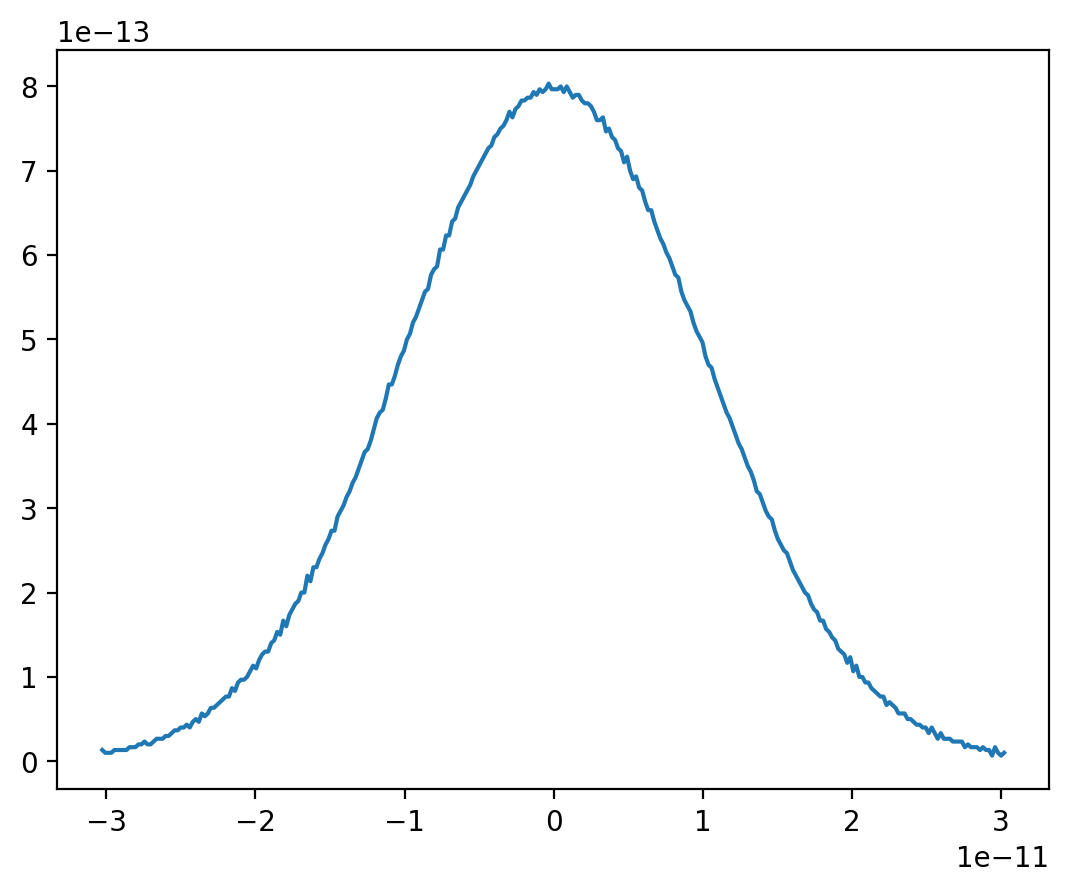

In [26]:
plt.plot(t, I);

In [27]:
ps = np.linspace(1, 12, 50)

Text(0, 0.5, '$\\rho$ ($s^{-1}$)')

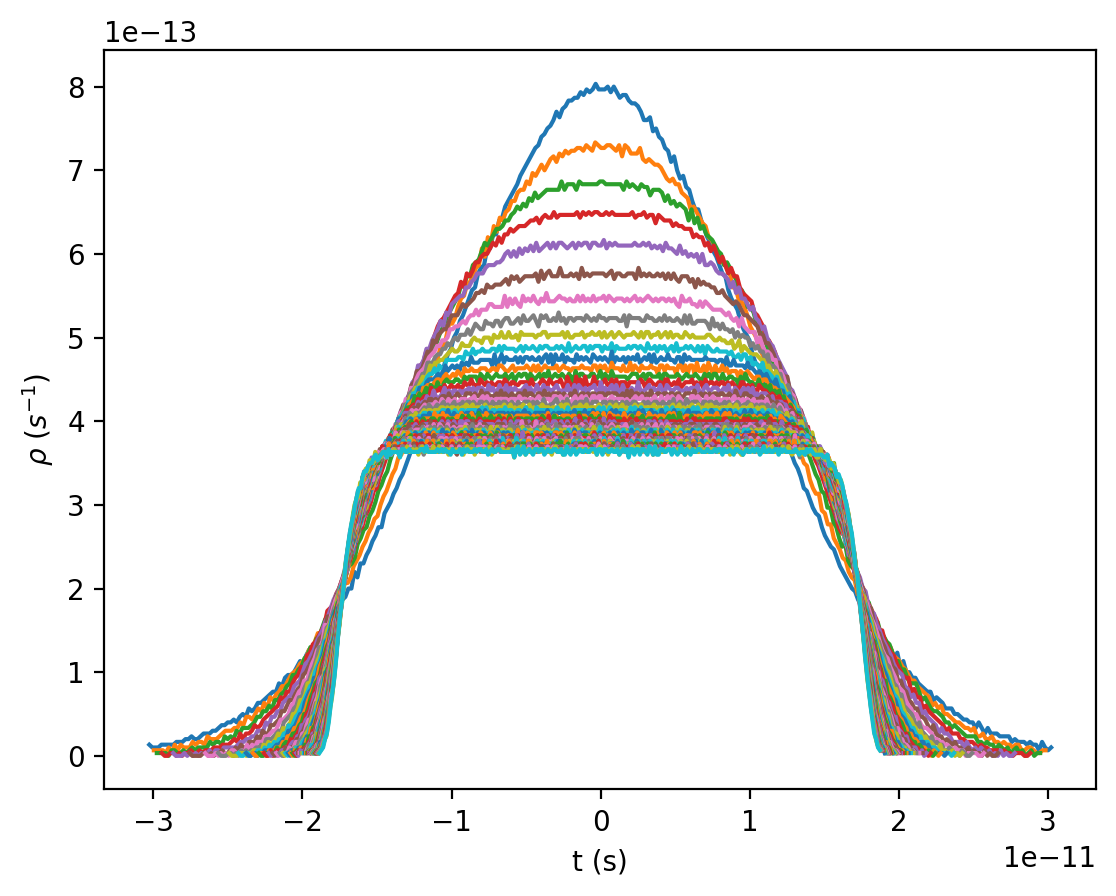

In [40]:
kldivs = np.zeros(ps.shape)
res2s = np.zeros(ps.shape)

for ii, p in enumerate(ps):
    
    D['t_dist:p']=p
    
    P = D.run()
    
    t, I = get_current_profile(P)
    
    plt.plot(t, I)
    
    kldivs[ii] = rms_equivalent_current_nonuniformity(P, method='kl_div', p=12)
    
    res2s[ii] = rms_equivalent_current_nonuniformity(P, method='res2')

plt.xlabel('t (s)')
plt.ylabel('$\\rho$ ($s^{-1}$)')

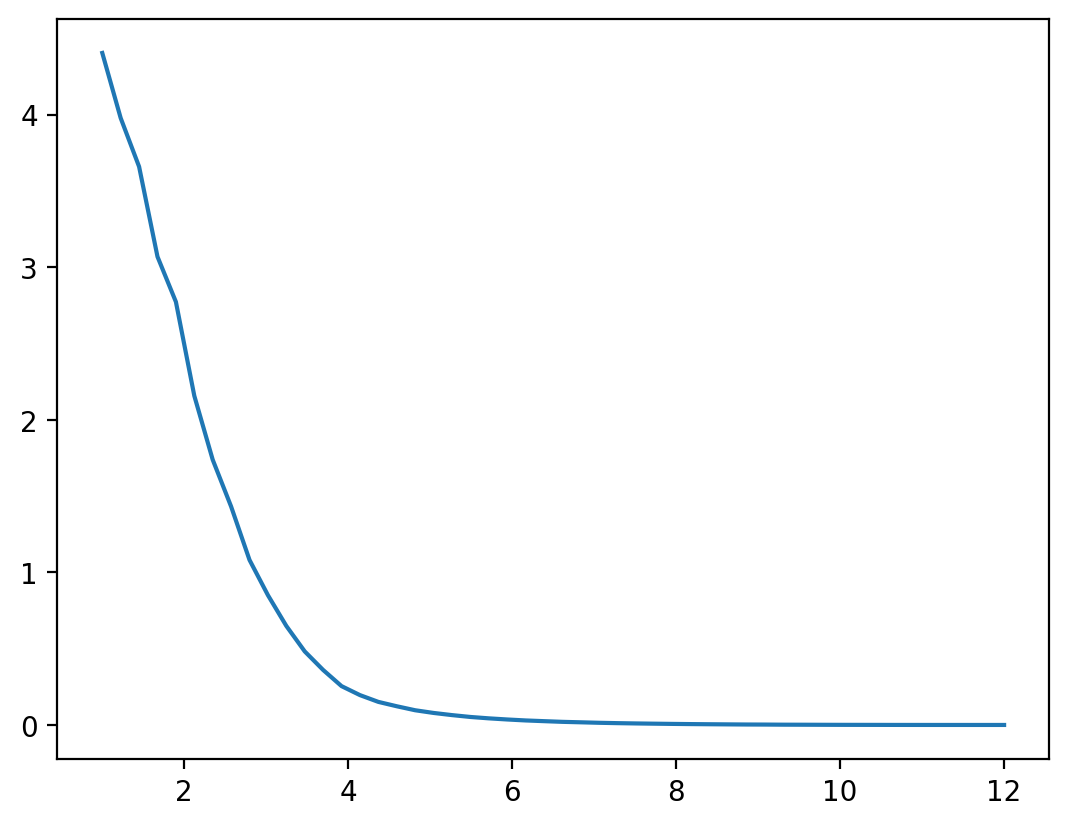

In [29]:
plt.plot(ps, kldivs);

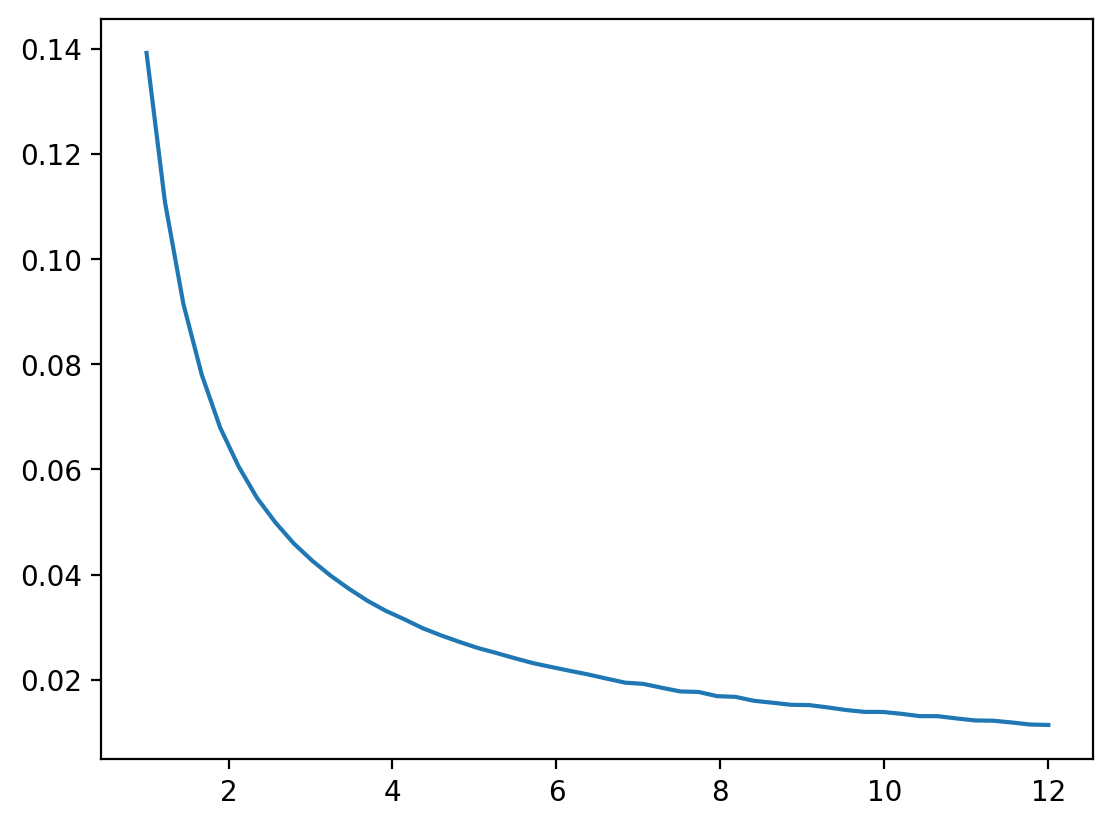

In [34]:
plt.plot(ps, res2s);

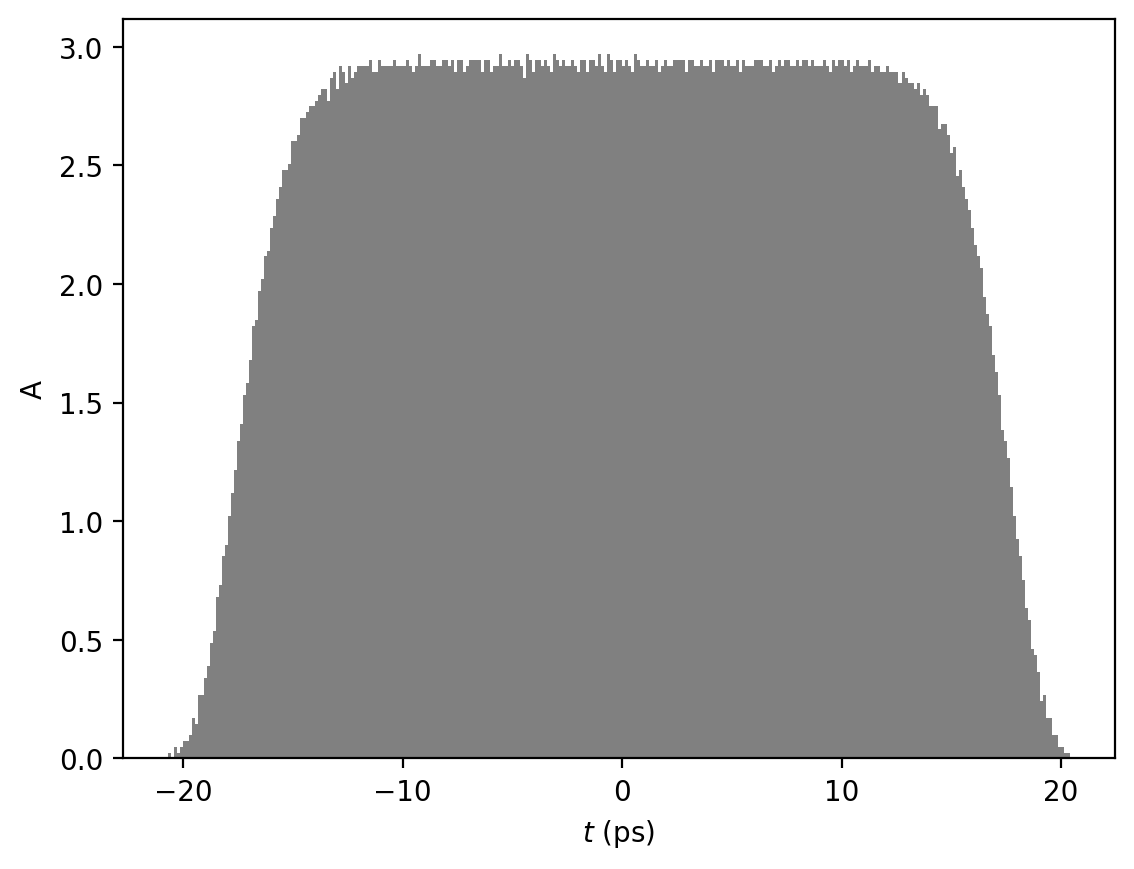

In [31]:
D['t_dist:p']=6
P = D.run()
P.plot('t')